# Quiz Two

## Your Name: Ruchita Raghunandan

## INFO 3440 | March 13th, 2023

## Instructions:
Solve all problems in python to the best of your ability. You are welcome to use Excel in order to check your answers, but you must submit a python notebook exported as an html file to receive full credit. Furthermore, feel free to collaborate with your fellow classmates. You need to turn in your own copy of the notebook. Make sure your name is on the top of the notebook and is visible when you export it to html.

### Due Date: Wednesday, March 17 2023 at 11.59pm

In [1]:
import pandas as pd
import pyomo.environ as pe
import matplotlib.pyplot as plt
import seaborn as sns

## Problem One: Flavors

In this problem, we have five flavors of products that we can make: Apple, Banana, Chocolate, Elderberry, and Fig. The price for each product is listed along with the expected price if they are produced. We want to maximize our profit and determine how many of each product we should make. The data are given in the `flavors` tab of the `quiz-2.xlsx` spreadsheet. Note that there are both Fixed and Variable Costs because we do not have to make each product. 

### DATA SETUP

#### IMPORTING DATA

In [2]:
FlavorData = pd.read_excel('quiz-2.xlsx', sheet_name='flavors')
FlavorData

Data        Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4  Unnamed: 5  \
0    NaN               NaN        NaN        NaN        NaN         NaN   
1    NaN    Units Required      Apple     Banana  Chocolate  Elderberry   
2    NaN            Mixing          5          6          7           3   
3    NaN       Preparation          3          5          6           6   
4    NaN          Blending          4          4          4           3   
5    NaN         Packaging          2          3          3           5   
6    NaN               NaN        NaN        NaN        NaN         NaN   
7    NaN               NaN      Apple     Banana  Chocolate  Elderberry   
8    NaN  Fixed Setup cost         60         78         91          40   
9    NaN     Cost/unit ($)        3.2        3.7        3.9         3.8   
10   NaN        Price/unit        5.5        6.2        4.5         3.9   
11   NaN    Demand ceiling        200        200        200         200   

   Unnamed: 6       Unnamed: 7  
0         NaN              NaN  
1         Fig  Units Available  
2           4             2700  
3           6             2700  
4           4             2500  
5           5             2500  
6         NaN              NaN  
7         Fig              NaN  
8          40              NaN  
9         3.1              NaN  
10        5.1              NaN  
11        200              NaN

#### CREATING COEFFICIENTS AND DATAFRAMES

In [3]:
# Coefficient tables and decison variables
DV_indexes = ['Apple', 'Banana', 'Chocolate', 'Elderberry', 'Fig']
coef = pd.DataFrame(FlavorData.iloc[[8,9,10,11], 2:7])
coef.index = ['Fixed Cost', 'Var Cost', 'Price', 'Demand']
coef.columns = DV_indexes
coef

Apple Banana Chocolate Elderberry  Fig
Fixed Cost    60     78        91         40   40
Var Cost     3.2    3.7       3.9        3.8  3.1
Price        5.5    6.2       4.5        3.9  5.1
Demand       200    200       200        200  200

In [4]:
# Creating coefficients for constraints
coef2 = pd.DataFrame(FlavorData.iloc[[2,3,4,5], 2:7])
coef2.index = ['Mixing', 'Preparation', 'Blending', 'Packaging']
coef2.columns = DV_indexes
coef2

Apple Banana Chocolate Elderberry Fig
Mixing          5      6         7          3   4
Preparation     3      5         6          6   6
Blending        4      4         4          3   4
Packaging       2      3         3          5   5

In [5]:
# Units Available Dataframe
RHS = pd.DataFrame(FlavorData.iloc[[2,3,4,5], 7])
RHS.index = ['Mixing', 'Preparation', 'Blending', 'Packaging']
RHS

Unnamed: 7
Mixing            2700
Preparation       2700
Blending          2500
Packaging         2500

### MODEL SETUP

#### Creating the Model

In [6]:
# Setting model
model = pe.ConcreteModel()

In [7]:
# Creating decision variables
model.x = pe.Var(DV_indexes, domain = pe.NonNegativeIntegers)
model.y = pe.Var(DV_indexes, domain = pe.Binary)
model.x.pprint()
model.y.pprint()

x : Size=5, Index=x_index
    Key        : Lower : Value : Upper : Fixed : Stale : Domain
         Apple :     0 :  None :  None : False :  True : NonNegativeIntegers
        Banana :     0 :  None :  None : False :  True : NonNegativeIntegers
     Chocolate :     0 :  None :  None : False :  True : NonNegativeIntegers
    Elderberry :     0 :  None :  None : False :  True : NonNegativeIntegers
           Fig :     0 :  None :  None : False :  True : NonNegativeIntegers
y : Size=5, Index=y_index
    Key        : Lower : Value : Upper : Fixed : Stale : Domain
         Apple :     0 :  None :     1 : False :  True : Binary
        Banana :     0 :  None :     1 : False :  True : Binary
     Chocolate :     0 :  None :     1 : False :  True : Binary
    Elderberry :     0 :  None :     1 : False :  True : Binary
           Fig :     0 :  None :     1 : False :  True : Binary


In [8]:
#Creating objective function
model.obj = pe.Objective(expr = sum([coef.loc['Price', index]*model.x[index] for index in DV_indexes])-sum([coef.loc['Fixed Cost', index]*model.y[index] for index in DV_indexes])-sum([coef.loc['Var Cost', index]*model.x[index] for index in DV_indexes]), 
                         sense = pe.maximize)
model.obj.pprint()

obj : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : 5.5*x[Apple] + 6.2*x[Banana] + 4.5*x[Chocolate] + 3.9*x[Elderberry] + 5.1*x[Fig] - (60*y[Apple] + 78*y[Banana] + 91*y[Chocolate] + 40*y[Elderberry] + 40*y[Fig]) - (3.2*x[Apple] + 3.7*x[Banana] + 3.9*x[Chocolate] + 3.8*x[Elderberry] + 3.1*x[Fig])


In [9]:
# Creating Constraints
model.cons_mix = pe.Constraint(expr = sum([coef2.loc['Mixing', idx]*model.x[idx] 
                                             for idx in DV_indexes]) <= RHS.loc['Mixing', 'Unnamed: 7'])
model.cons_prep = pe.Constraint(expr = sum([coef2.loc['Preparation', idx]*model.x[idx] 
                                             for idx in DV_indexes]) <= RHS.loc['Preparation', 'Unnamed: 7'])
model.cons_blend = pe.Constraint(expr = sum([coef2.loc['Blending', idx]*model.x[idx] 
                                             for idx in DV_indexes]) <= RHS.loc['Blending', 'Unnamed: 7'])
model.cons_pack = pe.Constraint(expr = sum([coef2.loc['Packaging', idx]*model.x[idx] 
                                             for idx in DV_indexes]) <= RHS.loc['Packaging', 'Unnamed: 7'])
model.cons_Aunits = pe.Constraint(expr = model.x['Apple'] <= model.y['Apple']*coef.loc['Demand','Apple'])
model.cons_Bunits = pe.Constraint(expr = model.x['Banana'] <= model.y['Banana']*coef.loc['Demand','Banana'])
model.cons_Cunits = pe.Constraint(expr = model.x['Chocolate'] <= model.y['Chocolate']*coef.loc['Demand','Chocolate'])
model.cons_Eunits = pe.Constraint(expr = model.x['Elderberry'] <= model.y['Elderberry']*coef.loc['Demand','Elderberry'])
model.cons_Funits = pe.Constraint(expr = model.x['Fig'] <= model.y['Fig']*coef.loc['Demand','Fig'])

In [10]:
# Solving the model
opt = pe.SolverFactory('glpk')
success = opt.solve(model)
print(success.solver.status, success.solver.termination_condition)

ok optimal


In [11]:
#Checking optimal value/objective function value
obj_val = model.obj.expr()
obj_val

1057.0

In [12]:
# Printing the results/decision variables as a dataframe
results = pd.DataFrame()
for DV in model.component_objects(pe.Var):
    for var in DV:
        results.loc[DV.name, var] = DV[var].value
results

Apple  Banana  Chocolate  Elderberry    Fig
x  200.0   150.0        0.0         0.0  200.0
y    1.0     1.0        0.0         0.0    1.0

### Problem 1a

How many of each product (flavor) should we produce in order to maximize profit? 

In [13]:
print("The following decision has been made regarding what flavors to make and how much of those as well.")
results

The following decision has been made regarding what flavors to make and how much of those as well.


Apple  Banana  Chocolate  Elderberry    Fig
x  200.0   150.0        0.0         0.0  200.0
y    1.0     1.0        0.0         0.0    1.0

In [14]:
print(f'The optimal profit given the above results is: ${obj_val:.2f}')

The optimal profit given the above results is: $1057.00


### Problem 1b

Suppose we need at least one of Chocolate or Elderberry to be produced. How many of each product should we produce in order to maximize profit?

In [15]:
# Running loop for model to be run, adds new constraint
def run_model():
    model = pe.ConcreteModel()
    # Define Decision Variables
    model.x = pe.Var(DV_indexes, domain = pe.NonNegativeIntegers)
    model.y = pe.Var(DV_indexes, domain = pe.Binary)
    # Define Objective Function for profit
    model.obj = pe.Objective(expr = sum([coef.loc['Price', index]*model.x[index] for index in DV_indexes])-sum([coef.loc['Fixed Cost', index]*model.y[index] for index in DV_indexes])-sum([coef.loc['Var Cost', index]*model.x[index] for index in DV_indexes]), 
                         sense = pe.maximize)
    
    #Units Constraints
    model.cons_mix = pe.Constraint(expr = sum([coef2.loc['Mixing', idx]*model.x[idx] 
                                             for idx in DV_indexes]) <= RHS.loc['Mixing', 'Unnamed: 7'])
    model.cons_prep = pe.Constraint(expr = sum([coef2.loc['Preparation', idx]*model.x[idx] 
                                             for idx in DV_indexes]) <= RHS.loc['Preparation', 'Unnamed: 7'])
    model.cons_blend = pe.Constraint(expr = sum([coef2.loc['Blending', idx]*model.x[idx] 
                                             for idx in DV_indexes]) <= RHS.loc['Blending', 'Unnamed: 7'])
    model.cons_pack = pe.Constraint(expr = sum([coef2.loc['Packaging', idx]*model.x[idx] 
                                             for idx in DV_indexes]) <= RHS.loc['Packaging', 'Unnamed: 7'])
    #Demand Constraints
    model.cons_Aunits = pe.Constraint(expr = model.x['Apple'] <= model.y['Apple']*coef.loc['Demand','Apple'])
    model.cons_Bunits = pe.Constraint(expr = model.x['Banana'] <= model.y['Banana']*coef.loc['Demand','Banana'])
    model.cons_Cunits = pe.Constraint(expr = model.x['Chocolate'] <= model.y['Chocolate']*coef.loc['Demand','Chocolate'])
    model.cons_Eunits = pe.Constraint(expr = model.x['Elderberry'] <= model.y['Elderberry']*coef.loc['Demand','Elderberry'])
    model.cons_Funits = pe.Constraint(expr = model.x['Fig'] <= model.y['Fig']*coef.loc['Demand','Fig'])
    # Constraint for at least 1 - Chocolate or Elderberry
    model.cons_ChocElde = pe.Constraint(expr = model.y['Chocolate'] + model.y['Elderberry']  >= 1)
    model.cons_ChocElde2 = pe.Constraint(expr = model.x['Chocolate'] + model.x['Elderberry']  >= 1)
    opt = pe.SolverFactory('glpk')
    #opt.solve(model,tee=True) 
    success=opt.solve(model)
    return model

In [16]:
# Running and solving model
model = run_model()

# Printing results - objective function
obj_val2 = model.obj.expr()
print(f'The new optimal objective value/maximum profit = ${obj_val2:.2f}')

The new optimal objective value/maximum profit = $1015.30


In [17]:
# Printing results - decision variables
results_original = results.copy()

new_results = pd.DataFrame()
for DV in model.component_objects(pe.Var):
    for var in DV:
        new_results.loc[DV.name, var] = DV[var].value

In [18]:
print("The following decision has been changed regarding what flavors to make and how much of those as well.")
new_results

The following decision has been changed regarding what flavors to make and how much of those as well.


Apple  Banana  Chocolate  Elderberry    Fig
x  199.0   151.0        0.0         1.0  199.0
y    1.0     1.0        0.0         1.0    1.0

## Problem Two: Optimal Placement

A local coffee chain has fifteen shops located throughout the metro area. The $(x, y)$ locations are located in the `locations` tab of `quiz-2.xlsx`. Management wants to re-located their roasting facility to a more central location in the city. Use $D_k = ((x - x_k)^2 + (y - y_k)^2)^{0.5}$ as the distance metric between each pair of points.

#### DATA SETUP

In [19]:
# Reading Data
LocationData = pd.read_excel('quiz-2.xlsx', sheet_name='locations')
LocationData

site   x   y
0      1   5  29
1      2   9  50
2      3  15  31
3      4  21  44
4      5  26  68
5      6  59  79
6      7  39  65
7      8  40  40
8      9  41  54
9     10  49  59
10    11  63  42
11    12  72  58
12    13  81  76
13    14  84  95
14    15  95  93
15    16  98  73

### Problem 2a

Use `seaborn` to plot the locations.

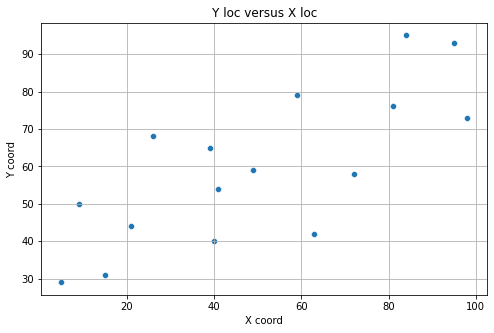

In [20]:
plt.figure(figsize = (8,5))
sns.scatterplot(x = 'x', y = 'y', data = LocationData)
plt.title('Y loc versus X loc')
plt.ylabel('Y coord')
plt.xlabel('X coord')
plt.grid()
plt.show()

### Problem 2b

Identify the optimal location of the roasting facility by minimizing the total distance from the new facility to each of the fifteen shops. 

In [21]:
# Creating the model
model2 = pe.ConcreteModel()

In [22]:
# Creating the decision variables
model2.x = pe.Var(domain = pe.NonNegativeReals)
model2.y = pe.Var(domain = pe.NonNegativeReals)

model2.x.pprint()
model2.y.pprint()

x : Size=1, Index=None
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :     0 :  None :  None : False :  True : NonNegativeReals
y : Size=1, Index=None
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :     0 :  None :  None : False :  True : NonNegativeReals


In [23]:
# Creating the objective function
data_rows = range(16)

model2.obj = pe.Objective(expr = sum(((LocationData.loc[row,'y']-model2.y)**2 + (LocationData.loc[row,'x']-model2.x)**2)**0.5
                         for row in data_rows))

model2.obj.pprint()

obj : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : ((29 - y)**2 + (5 - x)**2)**0.5 + ((50 - y)**2 + (9 - x)**2)**0.5 + ((31 - y)**2 + (15 - x)**2)**0.5 + ((44 - y)**2 + (21 - x)**2)**0.5 + ((68 - y)**2 + (26 - x)**2)**0.5 + ((79 - y)**2 + (59 - x)**2)**0.5 + ((65 - y)**2 + (39 - x)**2)**0.5 + ((40 - y)**2 + (40 - x)**2)**0.5 + ((54 - y)**2 + (41 - x)**2)**0.5 + ((59 - y)**2 + (49 - x)**2)**0.5 + ((42 - y)**2 + (63 - x)**2)**0.5 + ((58 - y)**2 + (72 - x)**2)**0.5 + ((76 - y)**2 + (81 - x)**2)**0.5 + ((95 - y)**2 + (84 - x)**2)**0.5 + ((93 - y)**2 + (95 - x)**2)**0.5 + ((73 - y)**2 + (98 - x)**2)**0.5


In [24]:
# Solving the model
opt = pe.SolverFactory('ipopt')
result = opt.solve(model2)
print(result.solver.status, result.solver.termination_condition)

ok optimal


In [25]:
# Checking optimal solution/objective function value
obj_val2 = model2.obj.expr()
print(f'The minimized distance or optimal objective value is = {obj_val2:.2f}')

The minimized distance or optimal objective value is = 498.84


In [26]:
# Printing the results - X and Y coordinates
opt_x = model2.x.value
opt_y = model2.y.value
print("The x coordinate is " + str(round(opt_x,2)))
print("The y coordinate is " + str(round(opt_y,2)))

The x coordinate is 48.28
The y coordinate is 58.79


### Problem 2c

Using `seaborn`, add the new location to the plot from Problem 2a. 

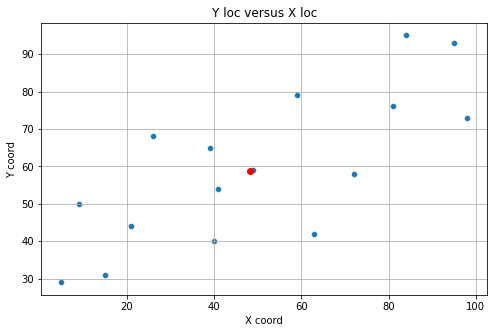

In [27]:
plt.figure(figsize = (8,5))
sns.scatterplot(x = 'x', y = 'y', data = LocationData)
plt.scatter(x = opt_x, y = opt_y, color='Red')
plt.title('Y loc versus X loc')
plt.ylabel('Y coord')
plt.xlabel('X coord')
plt.grid()
plt.show()